In [ ]:
pip install ultralytics shapely -q
import os
import cv2
import numpy as np
import math
from ultralytics import YOLO
from shapely.geometry import Polygon, Point
from PIL import Image
from IPython.display import display

In [ ]:

MODEL_FILE = 'TRAINED_MODEL/best.pt'
IMAGE_FILE = 'test1.jpg'

if os.path.exists(MODEL_FILE) and os.path.exists(IMAGE_FILE):
    print(f"Loading {MODEL_FILE}...")
    model = YOLO(MODEL_FILE)

    print(f"📸 Running prediction on {IMAGE_FILE}...")
    results = model.predict(IMAGE_FILE, save=True, conf=0.25)

    annotated_img = results[0].plot()
    display(Image.fromarray(annotated_img[..., ::-1]))

else:
    print("Error: Please check that you uploaded 'best.pt' and your image!")

In [ ]:
unzip "/content/drive/MyDrive/Ideathon/solar_dataset.zip" -d /content/dataset

In [ ]:
from ultralytics import YOLO

model = YOLO("/content/drive/MyDrive/Ideathon/TRAINED_MODEL/best.pt")

print("📊 Starting Validation on Test Set...")
metrics = model.val(data="dataset/data.yaml", split="test")

print(f"🎯 mAP50 (Accuracy): {metrics.seg.map50}")
print(f"🎯 mAP50-95 (Strict Accuracy): {metrics.seg.map}")

In [ ]:
pip install ultralytics shapely -q

import cv2
import numpy as np
import math
from shapely.geometry import Polygon, Point
from ultralytics import YOLO


def calculate_radius_from_sqft(area_sqft):
    """Converts Area (sq.ft) -> Radius (meters)."""
    # 1 sq ft = 0.092903 sq meters
    area_sqm = area_sqft * 0.092903
    # Area = pi * r^2  -->  r = sqrt(Area / pi)
    radius_meters = math.sqrt(area_sqm / math.pi)
    return radius_meters

def get_best_panel(buffer_circle, panels, gsd):
    """
    Finds the panel with the largest overlap inside the buffer circle.
    Returns: (best_panel_polygon, total_area_sqm) or (None, 0)
    """
    max_overlap_area = 0
    best_panel = None

    for panel in panels:
        # Calculate intersection (Green Area in your diagram)
        intersection = buffer_circle.intersection(panel)
        overlap_area = intersection.area

        # We want the panel with the LARGEST overlapping area
        if overlap_area > max_overlap_area:
            max_overlap_area = overlap_area
            best_panel = panel

    if best_panel:
        # Start "Quantify" Logic: Return the TOTAL area of the chosen panel
        # Total Area = Polygon Area (pixels) * GSD^2
        total_area_pixels = best_panel.area
        total_area_sqm = total_area_pixels * (gsd ** 2)
        return best_panel, total_area_sqm

    return None, 0

def process_site_logic(image, results, gsd=0.15):
    """
    Implements the 2-step Buffer Logic:
    1. Check 1200 sq.ft buffer.
    2. If fails, check 2400 sq.ft buffer.
    """
    h, w = image.shape[:2]
    center_point = Point(w / 2, h / 2) # Assuming (lat, lon) is the image center

    # 1. Extract all detected Solar Panels as Polygons
    detected_panels = []
    if results[0].masks is not None:
        for mask_contour in results[0].masks.xy:
            if len(mask_contour) >= 3: # Need at least 3 points for a polygon
                detected_panels.append(Polygon(mask_contour))

    # --- STEP 1: CHECK 1200 SQ. FT BUFFER ---
    radius_1200_m = calculate_radius_from_sqft(1200)
    radius_1200_px = radius_1200_m / gsd
    buffer_1200 = center_point.buffer(radius_1200_px)

    best_panel, area = get_best_panel(buffer_1200, detected_panels, gsd)

    if best_panel:
        return {
            "has_solar": True,
            "buffer_radius_sqft": 1200,
            "pv_area_sqm_est": round(area, 2),
            "capacity_kw": round(area * 0.200, 2), # Approx 200W per sqm
            "qc_status": "VERIFIABLE"
        }

    # --- STEP 2: CHECK 2400 SQ. FT BUFFER ---
    radius_2400_m = calculate_radius_from_sqft(2400)
    radius_2400_px = radius_2400_m / gsd
    buffer_2400 = center_point.buffer(radius_2400_px)

    best_panel, area = get_best_panel(buffer_2400, detected_panels, gsd)

    if best_panel:
        return {
            "has_solar": True,
            "buffer_radius_sqft": 2400,
            "pv_area_sqm_est": round(area, 2),
            "capacity_kw": round(area * 0.200, 2),
            "qc_status": "VERIFIABLE"
        }

    # --- STEP 3: NO PANELS FOUND ---
    return {
        "has_solar": False,
        "buffer_radius_sqft": 2400,
        "pv_area_sqm_est": 0,
        "capacity_kw": 0,
        "qc_status": "VERIFIABLE" # Or NOT_VERIFIABLE depending on cloud check
    }

# ==========================================
# 3. RUN ON A TEST IMAGE
# ==========================================
# Load your trained model
model = YOLO('best.pt')  # Update path if needed

# Load an image (Replace with your test image path)
test_image_path = "HouseLowAngle.jpeg" # <--- UPDATE THIS
image = cv2.imread(test_image_path)

if image is not None:
    # Run Inference
    results = model.predict(image, conf=0.25)

    # Run the Logic
    # GSD = 0.1 meters/pixel (Update this based on your zoom level)
    final_output = process_site_logic(image, results, gsd=0.1)

    print("\n✅ FINAL JSON OUTPUT:")
    print(final_output)
else:
    print("❌ Error: Test image not found.")

--- CONFIG ---
Scale: 0.15 m/px
Buffer 1 (1200 sq.ft): 6.0m -> 39.7 px radius
Buffer 2 (2400 sq.ft): 8.4m -> 56.2 px radius
🧠 Loading Model...
📸 Running Inference...
🔍 Detected 3 total panels.
✅ STATUS: Found in Buffer 1 (1200 sq.ft)
   Relevant Panels: 1
   Total Area: 1101.00 sq.ft


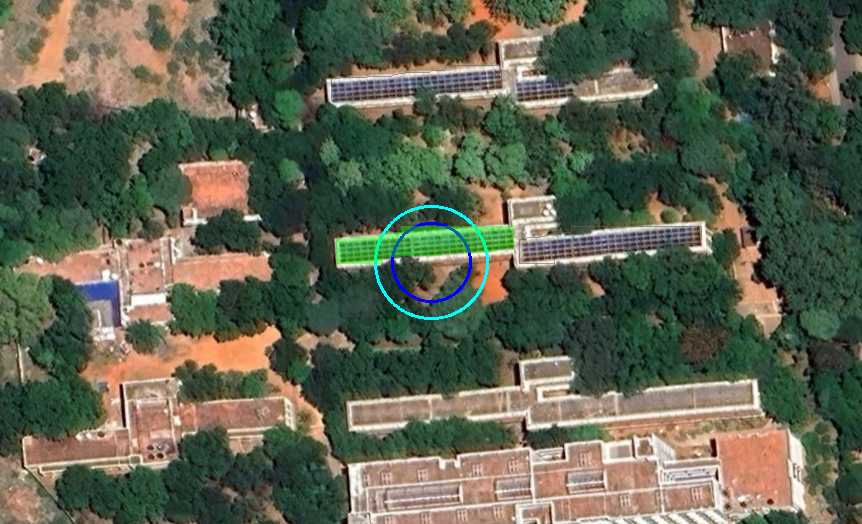

In [9]:
MODEL_PATH = 'TRAINED_MODEL/best.pt'
IMAGE_FILE = 'test_imgs/test5.png' 

# SATELLITE SCALE (CRITICAL)
# How many meters does 1 pixel represent?
# - Google Maps Max Zoom: ~0.15 m/px
# - Standard Satellite: ~0.3 - 0.5 m/px
METERS_PER_PIXEL = 0.15  

BUFFER_1_SQFT = 1200
BUFFER_2_SQFT = 2400

def sqft_to_sqmeters(sqft):
    return sqft * 0.092903

def area_to_radius_meters(area_sqm):
    return math.sqrt(area_sqm / math.pi)

def meters_to_pixels(meters, scale):
    return meters / scale

# --- 3. MAIN LOGIC ---
if os.path.exists(MODEL_PATH) and os.path.exists(IMAGE_FILE):
    # Calculate Buffer Radii in Pixels
    r1_m = area_to_radius_meters(sqft_to_sqmeters(BUFFER_1_SQFT))
    r1_px = meters_to_pixels(r1_m, METERS_PER_PIXEL)

    r2_m = area_to_radius_meters(sqft_to_sqmeters(BUFFER_2_SQFT))
    r2_px = meters_to_pixels(r2_m, METERS_PER_PIXEL)

    print(f"--- CONFIG ---")
    print(f"Scale: {METERS_PER_PIXEL} m/px")
    print(f"Buffer 1 (1200 sq.ft): {r1_m:.1f}m -> {r1_px:.1f} px radius")
    print(f"Buffer 2 (2400 sq.ft): {r2_m:.1f}m -> {r2_px:.1f} px radius")

    print(f"🧠 Loading Model...")
    model = YOLO(MODEL_PATH)
    img_cv2 = cv2.imread(IMAGE_FILE)
    h, w = img_cv2.shape[:2]
    cx, cy = w // 2, h // 2 # Assume center of image is target

    # Inference
    print(f"📸 Running Inference...")
    results = model.predict(IMAGE_FILE, conf=0.15, verbose=False)
    
    # Extract Polygons (shapely)
    all_panels = []
    if results[0].masks:
        for pts in results[0].masks.xy:
            if len(pts) >= 3:
                all_panels.append(Polygon(pts))
    
    print(f"🔍 Detected {len(all_panels)} total panels.")

    # Create Buffer Zones (shapely)
    center = Point(cx, cy)
    buffer1 = center.buffer(r1_px)
    buffer2 = center.buffer(r2_px)

    # --- THE BUFFER LOGIC ---
    valid_panels = []
    status = "No Panels in Buffer"
    active_zone = None
    
    # 1. Check Inner Buffer (1200)
    hits_b1 = [p for p in all_panels if p.intersects(buffer1)]
    
    if hits_b1:
        status = "Found in Buffer 1 (1200 sq.ft)"
        valid_panels = [p for p in all_panels if p.intersects(buffer1)]
        active_zone = (int(r1_px), (255, 0, 0)) # Blue
    else:
        # 2. Check Outer Buffer (2400)
        hits_b2 = [p for p in all_panels if p.intersects(buffer2)]
        if hits_b2:
            status = "Found in Buffer 2 (2400 sq.ft)"
            valid_panels = [p for p in all_panels if p.intersects(buffer2)]
            active_zone = (int(r2_px), (255, 255, 0)) # Cyan
        else:
            active_zone = (int(r2_px), (0, 0, 255)) # Red (Empty)

    # Calculate Area
    total_px_area = sum(p.area for p in valid_panels)
    total_ft_area = (total_px_area * (METERS_PER_PIXEL**2)) * 10.7639

    print(f"✅ STATUS: {status}")
    print(f"   Relevant Panels: {len(valid_panels)}")
    print(f"   Total Area: {total_ft_area:.2f} sq.ft")

    # --- 4. VISUALIZATION ---
    vis = img_cv2.copy()
    
    # Draw Buffers
    cv2.circle(vis, (cx, cy), int(r2_px), (255, 255, 0), 2) # Outer
    cv2.circle(vis, (cx, cy), int(r1_px), (255, 0, 0), 2)   # Inner
    
    # Draw Valid Panels GREEN
    overlay = vis.copy()
    for p in valid_panels:
        pts = np.array(p.exterior.coords, np.int32).reshape((-1, 1, 2))
        cv2.fillPoly(overlay, [pts], (0, 255, 0))
    
    # Draw Invalid Panels GRAY
    for p in all_panels:
        if p not in valid_panels:
            pts = np.array(p.exterior.coords, np.int32).reshape((-1, 1, 2))
            cv2.polylines(vis, [pts], True, (100, 100, 100), 1)

    cv2.addWeighted(overlay, 0.4, vis, 0.6, 0, vis)
    display(Image.fromarray(vis[..., ::-1]))

else:
    print("❌ Error: Check file paths.")